In [2]:
!nvidia-smi


Thu Nov 12 19:20:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

DESCARGAR DATASET



In [3]:
#!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

CONECTAR CON GOOGLE DRIVE

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir("/content/drive/My Drive/UNSA/8 semestre/Proyecto fin de carrera/data")
# DIV2K_train_HR.zip
!ls

images	masks


In [4]:
!ls
#!git clone https://github.com/MathiasGruber/PConv-Keras

images	masks


In [5]:
!pip install keras-tqdm
%tensorflow_version 1.x

TensorFlow 1.x selected.


GENERADOR DE MASCARAS

In [6]:
import os
from random import randint, seed
import itertools
import numpy as np
import cv2


class MaskGenerator():

    def __init__(self, height, width, channels=3, rand_seed=None, filepath=None):
        """Convenience functions for generating masks to be used for inpainting training
        
        Arguments:
            height {int} -- Mask height
            width {width} -- Mask width
        
        Keyword Arguments:
            channels {int} -- Channels to output (default: {3})
            rand_seed {[type]} -- Random seed (default: {None})
            filepath {[type]} -- Load masks from filepath. If None, generate masks with OpenCV (default: {None})
        """

        self.height = height
        self.width = width
        self.channels = channels
        self.filepath = filepath

        # If filepath supplied, load the list of masks within the directory
        self.mask_files = []
        if self.filepath:
            print(self.filepath)
            filenames = [f for f in os.listdir(self.filepath)]
            self.mask_files = [f for f in filenames if any(filetype in f.lower() for filetype in ['.jpeg', '.png', '.jpg'])]
            print(">> Found {} masks in {}".format(len(self.mask_files), self.filepath))        

        # Seed for reproducibility
        if rand_seed:
            seed(rand_seed)

    def _generate_mask(self):
        """Generates a random irregular mask with lines, circles and elipses"""

        img = np.zeros((self.height, self.width, self.channels), np.uint8)

        # Set size scale
        size = int((self.width + self.height) * 0.03)
        if self.width < 64 or self.height < 64:
            raise Exception("Width and Height of mask must be at least 64!")
        
        # Draw random lines
        for _ in range(randint(1, 20)):
            x1, x2 = randint(1, self.width), randint(1, self.width)
            y1, y2 = randint(1, self.height), randint(1, self.height)
            thickness = randint(3, size)
            cv2.line(img,(x1,y1),(x2,y2),(1,1,1),thickness)
            
        # Draw random circles
        for _ in range(randint(1, 20)):
            x1, y1 = randint(1, self.width), randint(1, self.height)
            radius = randint(3, size)
            cv2.circle(img,(x1,y1),radius,(1,1,1), -1)
            
        # Draw random ellipses
        for _ in range(randint(1, 20)):
            x1, y1 = randint(1, self.width), randint(1, self.height)
            s1, s2 = randint(1, self.width), randint(1, self.height)
            a1, a2, a3 = randint(3, 180), randint(3, 180), randint(3, 180)
            thickness = randint(3, size)
            cv2.ellipse(img, (x1,y1), (s1,s2), a1, a2, a3,(1,1,1), thickness)
        
        return 1-img

    def _load_mask(self, rotation=True, dilation=True, cropping=True):
        """Loads a mask from disk, and optionally augments it"""

        # Read image
        mask = cv2.imread(os.path.join(self.filepath, np.random.choice(self.mask_files, 1, replace=False)[0]))
        
        # Random rotation
        if rotation:
            rand = np.random.randint(-180, 180)
            M = cv2.getRotationMatrix2D((mask.shape[1]/2, mask.shape[0]/2), rand, 1.5)
            mask = cv2.warpAffine(mask, M, (mask.shape[1], mask.shape[0]))
            
        # Random dilation
        if dilation:
            rand = np.random.randint(5, 47)
            kernel = np.ones((rand, rand), np.uint8) 
            mask = cv2.erode(mask, kernel, iterations=1)
            
        # Random cropping
        if cropping:
            x = np.random.randint(0, mask.shape[1] - self.width)
            y = np.random.randint(0, mask.shape[0] - self.height)
            mask = mask[y:y+self.height, x:x+self.width]

        return (mask > 1).astype(np.uint8)

    def sample(self, random_seed=None):
        """Retrieve a random mask"""
        if random_seed:
            seed(random_seed)
        if self.filepath and len(self.mask_files) > 0:
            return self._load_mask()
        else:
            return self._generate_mask()


class ImageChunker(object): 
    
    def __init__(self, rows, cols, overlap):
        self.rows = rows
        self.cols = cols
        self.overlap = overlap
    
    def perform_chunking(self, img_size, chunk_size):
        """
        Given an image dimension img_size, return list of (start, stop) 
        tuples to perform chunking of chunk_size
        """
        chunks, i = [], 0
        while True:
            chunks.append((i*(chunk_size - self.overlap/2), i*(chunk_size - self.overlap/2)+chunk_size))
            i+=1
            if chunks[-1][1] > img_size:
                break
        n_count = len(chunks)        
        chunks[-1] = tuple(x - (n_count*chunk_size - img_size - (n_count-1)*self.overlap/2) for x in chunks[-1])
        chunks = [(int(x), int(y)) for x, y in chunks]
        return chunks
    
    def get_chunks(self, img, scale=1):
        """
        Get width and height lists of (start, stop) tuples for chunking of img.
        """
        x_chunks, y_chunks = [(0, self.rows)], [(0, self.cols)]        
        if img.shape[0] > self.rows:
            x_chunks = self.perform_chunking(img.shape[0], self.rows)
        else:
            x_chunks = [(0, img.shape[0])]
        if img.shape[1] > self.cols:
            y_chunks = self.perform_chunking(img.shape[1], self.cols)
        else:
            y_chunks = [(0, img.shape[1])]
        return x_chunks, y_chunks    
    
    def dimension_preprocess(self, img, padding=True):
        """
        In case of prediction on image of different size than 512x512,
        this function is used to add padding and chunk up the image into pieces
        of 512x512, which can then later be reconstructed into the original image
        using the dimension_postprocess() function.
        """
    
        # Assert single image input
        assert len(img.shape) == 3, "Image dimension expected to be (H, W, C)"
    
        # Check if we are adding padding for too small images
        if padding:
            
            # Check if height is too small
            if img.shape[0] < self.rows:
                padding = np.ones((self.rows - img.shape[0], img.shape[1], img.shape[2]))
                img = np.concatenate((img, padding), axis=0)
    
            # Check if width is too small
            if img.shape[1] < self.cols:
                padding = np.ones((img.shape[0], self.cols - img.shape[1], img.shape[2]))
                img = np.concatenate((img, padding), axis=1)
    
        # Get chunking of the image
        x_chunks, y_chunks = self.get_chunks(img)
    
        # Chunk up the image
        images = []
        for x in x_chunks:
            for y in y_chunks:
                images.append(
                    img[x[0]:x[1], y[0]:y[1], :]
                )
        images = np.array(images)        
        return images
    
    def dimension_postprocess(self, chunked_images, original_image, scale=1, padding=True):
        """
        In case of prediction on image of different size than 512x512,
        the dimension_preprocess  function is used to add padding and chunk 
        up the image into pieces of 512x512, and this function is used to 
        reconstruct these pieces into the original image.
        """
    
        # Assert input dimensions
        assert len(original_image.shape) == 3, "Image dimension expected to be (H, W, C)"
        assert len(chunked_images.shape) == 4, "Chunked images dimension expected to be (B, H, W, C)"
        
        # Check if we are adding padding for too small images
        if padding:
    
            # Check if height is too small
            if original_image.shape[0] < self.rows:
                new_images = []
                for img in chunked_images:
                    new_images.append(img[0:scale*original_image.shape[0], :, :])
                chunked_images = np.array(new_images)
    
            # Check if width is too small
            if original_image.shape[1] < self.cols:
                new_images = []
                for img in chunked_images:
                    new_images.append(img[:, 0:scale*original_image.shape[1], :])
                chunked_images = np.array(new_images)
            
        # Put reconstruction into this array
        new_shape = (
            original_image.shape[0]*scale,
            original_image.shape[1]*scale,
            original_image.shape[2]
        )
        reconstruction = np.zeros(new_shape)
            
        # Get the chunks for this image    
        x_chunks, y_chunks = self.get_chunks(original_image)
        
        i = 0
        s = scale
        for x in x_chunks:
            for y in y_chunks:
                
                prior_fill = reconstruction != 0
                chunk = np.zeros(new_shape)
                chunk[x[0]*s:x[1]*s, y[0]*s:y[1]*s, :] += chunked_images[i]
                chunk_fill = chunk != 0
                
                reconstruction += chunk
                reconstruction[prior_fill & chunk_fill] = reconstruction[prior_fill & chunk_fill] / 2
    
                i += 1
        
        return reconstruction

In [7]:
import os
import itertools
import matplotlib
import matplotlib.pyplot as plt

# Change to root path
if os.path.basename(os.getcwd()) != 'PConv-Keras':
    os.chdir('..')
    
# Import function that generates random masks

%matplotlib inline

In [8]:
??MaskGenerator._generate_mask

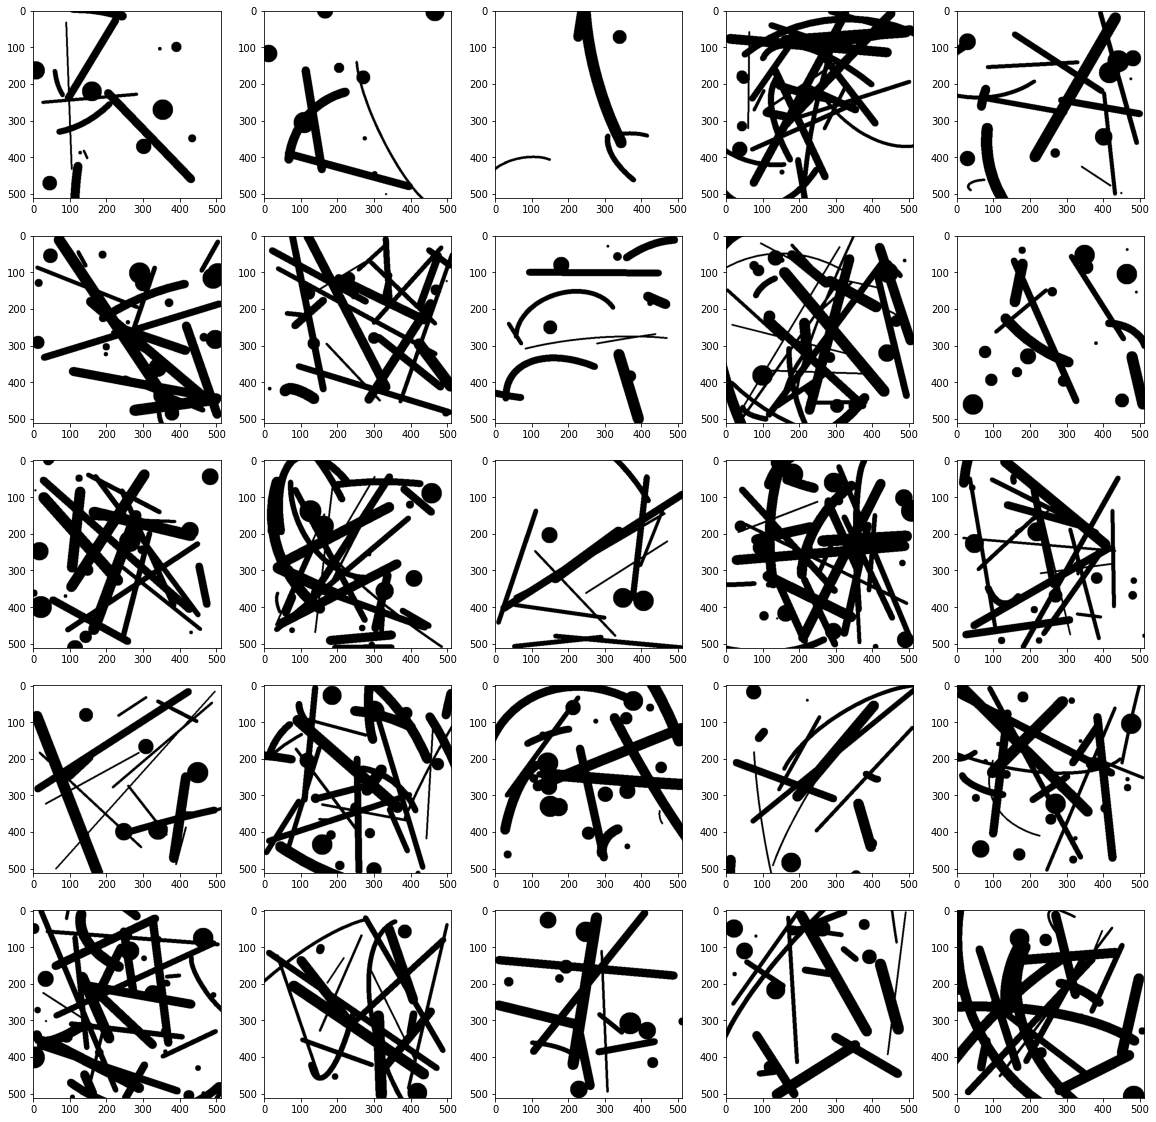

In [9]:
# Instantiate mask generator
mask_generator = MaskGenerator(512, 512, 3, rand_seed=42)

# Plot the results
_, axes = plt.subplots(5, 5, figsize=(20, 20))
axes = list(itertools.chain.from_iterable(axes))

for i in range(len(axes)):
    
    # Generate image
    img = mask_generator.sample()
    
    # Plot image on axis
    axes[i].imshow(img*255)

In [10]:
os.chdir("/content/drive/My Drive/UNSA/8 semestre/Proyecto fin de carrera/data/masks")
!ls
#!wget https://www.dropbox.com/s/qp8cxqttta4zi70/irregular_mask.zip
#!unzip irregular_mask.zip

irregular_mask.zip  test  test_mask.zip  train


In [11]:
os.chdir("/content/drive/My Drive/UNSA/8 semestre/Proyecto fin de carrera/data/masks/test")
#!wget https://www.dropbox.com/s/01dfayns9s0kevy/test_mask.zip
#!unzip test_mask.zip

In [12]:
!ls
#os.listdir('./train')

00000.png  01715.png  03430.png  05145.png  06860.png  08575.png  10290.png
00001.png  01716.png  03431.png  05146.png  06861.png  08576.png  10291.png
00002.png  01717.png  03432.png  05147.png  06862.png  08577.png  10292.png
00003.png  01718.png  03433.png  05148.png  06863.png  08578.png  10293.png
00004.png  01719.png  03434.png  05149.png  06864.png  08579.png  10294.png
00005.png  01720.png  03435.png  05150.png  06865.png  08580.png  10295.png
00006.png  01721.png  03436.png  05151.png  06866.png  08581.png  10296.png
00007.png  01722.png  03437.png  05152.png  06867.png  08582.png  10297.png
00008.png  01723.png  03438.png  05153.png  06868.png  08583.png  10298.png
00009.png  01724.png  03439.png  05154.png  06869.png  08584.png  10299.png
00010.png  01725.png  03440.png  05155.png  06870.png  08585.png  10300.png
00011.png  01726.png  03441.png  05156.png  06871.png  08586.png  10301.png
00012.png  01727.png  03442.png  05157.png  06872.png  08587.png  10302.png
00013.png  0

./train
>> Found 17353 masks in ./train


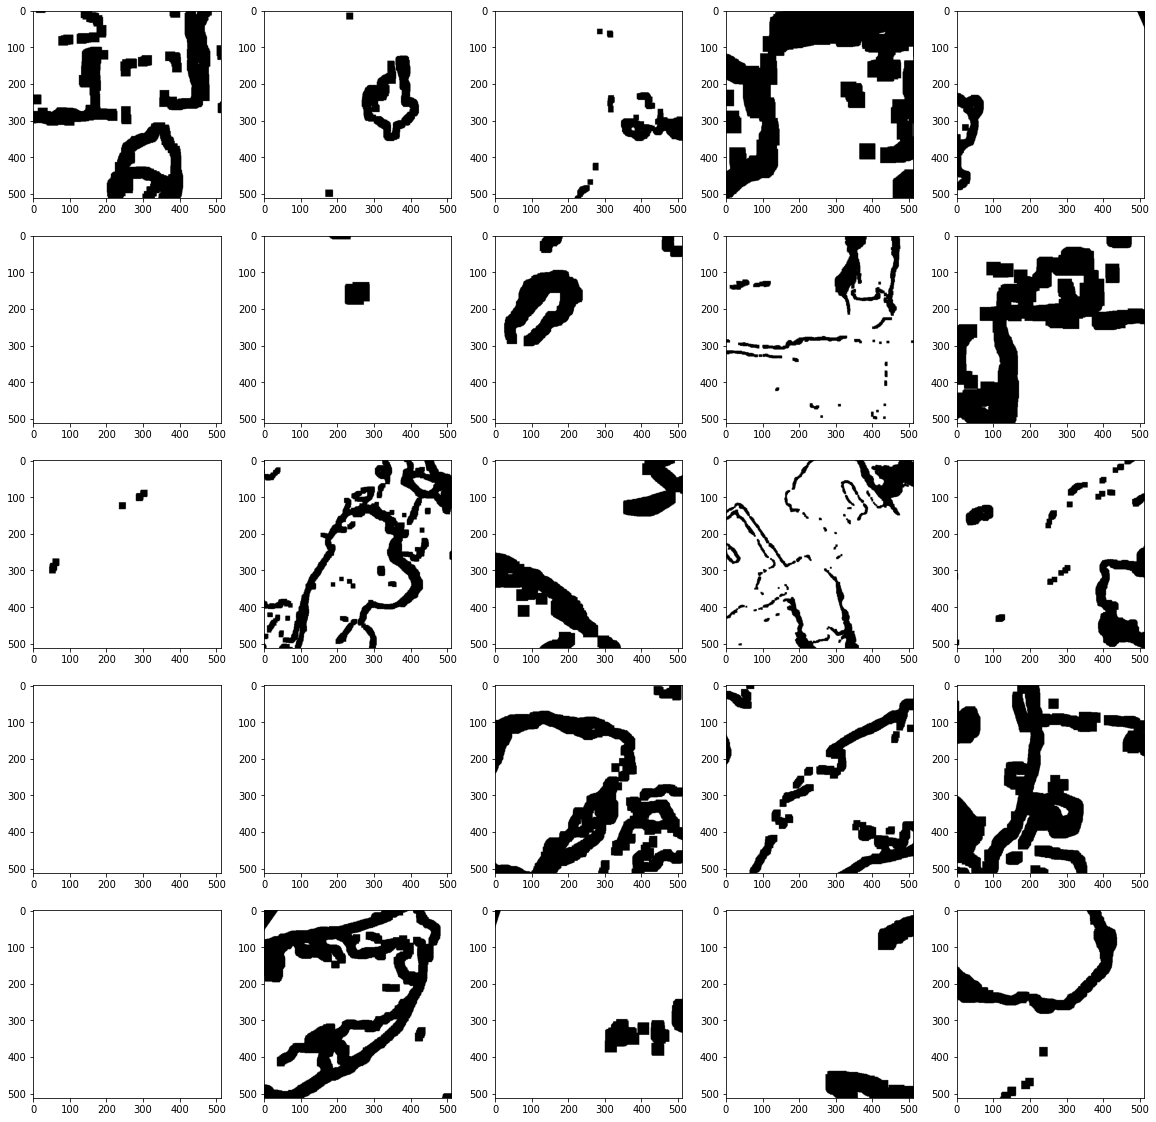

In [13]:
# Instantiate mask generator
os.chdir("/content/drive/My Drive/UNSA/8 semestre/Proyecto fin de carrera/data/masks")

mask_generator = MaskGenerator(512, 512, 3, rand_seed=42, filepath='./train')

# Plot the results
_, axes = plt.subplots(5, 5, figsize=(20, 20))
axes = list(itertools.chain.from_iterable(axes))

for i in range(len(axes)):
    
    # Generate image
    img = mask_generator.sample()
    
    # Plot image on axis
    axes[i].imshow(img*255)

CAPA CONVOLUCION PARCIAL

In [14]:
from keras.utils import conv_utils
from keras import backend as K
from keras.engine import InputSpec
from keras.layers import Conv2D


class PConv2D(Conv2D):
    def __init__(self, *args, n_channels=3, mono=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_spec = [InputSpec(ndim=4), InputSpec(ndim=4)]

    def build(self, input_shape):        
        """Adapted from original _Conv() layer of Keras        
        param input_shape: list of dimensions for [img, mask]
        """
        
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
            
        if input_shape[0][channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')
            
        self.input_dim = input_shape[0][channel_axis]
        
        # Image kernel
        kernel_shape = self.kernel_size + (self.input_dim, self.filters)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='img_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        # Mask kernel
        self.kernel_mask = K.ones(shape=self.kernel_size + (self.input_dim, self.filters))

        # Calculate padding size to achieve zero-padding
        self.pconv_padding = (
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)), 
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)), 
        )

        # Window size - used for normalization
        self.window_size = self.kernel_size[0] * self.kernel_size[1]
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, mask=None):
        '''
        We will be using the Keras conv2d method, and essentially we have
        to do here is multiply the mask with the input X, before we apply the
        convolutions. For the mask itself, we apply convolutions with all weights
        set to 1.
        Subsequently, we clip mask values to between 0 and 1
        ''' 

        # Both image and mask must be supplied
        if type(inputs) is not list or len(inputs) != 2:
            raise Exception('PartialConvolution2D must be called on a list of two tensors [img, mask]. Instead got: ' + str(inputs))

        # Padding done explicitly so that padding becomes part of the masked partial convolution
        images = K.spatial_2d_padding(inputs[0], self.pconv_padding, self.data_format)
        masks = K.spatial_2d_padding(inputs[1], self.pconv_padding, self.data_format)

        # Apply convolutions to mask
        mask_output = K.conv2d(
            masks, self.kernel_mask, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Apply convolutions to image
        img_output = K.conv2d(
            (images*masks), self.kernel, 
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )        

        # Calculate the mask ratio on each pixel in the output mask
        mask_ratio = self.window_size / (mask_output + 1e-8)

        # Clip output to be between 0 and 1
        mask_output = K.clip(mask_output, 0, 1)

        # Remove ratio values where there are holes
        mask_ratio = mask_ratio * mask_output

        # Normalize iamge output
        img_output = img_output * mask_ratio

        # Apply bias only to the image (if chosen to do so)
        if self.use_bias:
            img_output = K.bias_add(
                img_output,
                self.bias,
                data_format=self.data_format)
        
        # Apply activations on the image
        if self.activation is not None:
            img_output = self.activation(img_output)
            
        return [img_output, mask_output]
    
    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[0][1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0][0],) + tuple(new_space) + (self.filters,)
            return [new_shape, new_shape]
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0], self.filters) + tuple(new_space)
            return [new_shape, new_shape]

Using TensorFlow backend.


In [15]:
import os
from copy import deepcopy
import cv2
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, ZeroPadding2D
from keras.models import Model

# Change to root path
if os.path.basename(os.getcwd()) != 'PConv-Keras':
    os.chdir('..')

# Import modules from libs/ directory


%matplotlib inline
%load_ext autoreload
%autoreload 2

PROBAR CARGA DE IMAGENES

Shape of image is: (1848, 2040, 3)


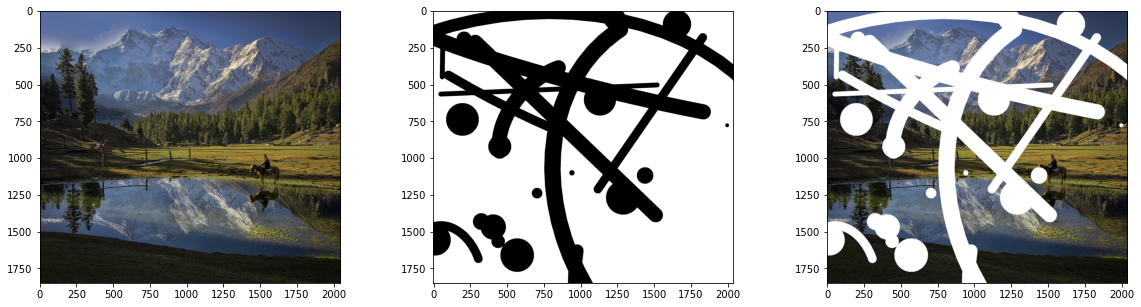

In [16]:
os.chdir("/content/drive/My Drive/UNSA/8 semestre/Proyecto fin de carrera/data/images")
img = cv2.imread('0002.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
shape = img.shape
print(f"Shape of image is: {shape}")

# Instantiate mask generator
mask_generator = MaskGenerator(shape[0], shape[1], 3, rand_seed=42)

# Load mask
mask = mask_generator.sample()

# Image + mask
masked_img = deepcopy(img)
masked_img[mask==0] = 255

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(mask*255)
axes[2].imshow(masked_img)
plt.show()

DEFINICION MODELO

In [17]:
# Input images and masks
input_img = Input(shape=(shape[0], shape[1], shape[2],))
input_mask = Input(shape=(shape[0], shape[1], shape[2],))
output_img, output_mask1 = PConv2D(8, kernel_size=(7,7), strides=(2,2))([input_img, input_mask])
output_img, output_mask2 = PConv2D(16, kernel_size=(5,5), strides=(2,2))([output_img, output_mask1])
output_img, output_mask3 = PConv2D(32, kernel_size=(5,5), strides=(2,2))([output_img, output_mask2])
output_img, output_mask4 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask3])
output_img, output_mask5 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask4])
output_img, output_mask6 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask5])
output_img, output_mask7 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask6])
output_img, output_mask8 = PConv2D(64, kernel_size=(3,3), strides=(2,2))([output_img, output_mask7])

# Create model
model = Model(
    inputs=[input_img, input_mask], 
    outputs=[
        output_img, output_mask1, output_mask2, 
        output_mask3, output_mask4, output_mask5,
        output_mask6, output_mask7, output_mask8
    ])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Show summary of the model
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'p_conv2d_1/Variable:0' shape=(7, 7, 3, 8) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_2/Variable:0' shape=(5, 5, 8, 16) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_3/Variable:0' shape=(5, 5, 16, 32) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_4/Variable:0' shape=(3, 3, 32, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_5/Variable:0' shape=(3, 3, 64, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_6/Variable:0' shape=(3, 3, 64, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_7/Variable:0' shape=(3, 3, 64, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_8/Variable:0' shape=(3, 3, 64, 64) dtype=float32> kernel_mask
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         P


Comprobacion de actualizaciones de la capa de máscara

In [18]:
formatted_img = np.expand_dims(masked_img, 0) / 255
formatted_mask = np.expand_dims(mask, 0)
print(f"Original Mask Shape: {formatted_mask.shape} - Max value in mask: {np.max(formatted_mask)}")

output_img, o1, o2, o3, o4, o5, o6, o7, o8 = model.predict([formatted_img, formatted_mask])

Original Mask Shape: (1, 1848, 2040, 3) - Max value in mask: 1



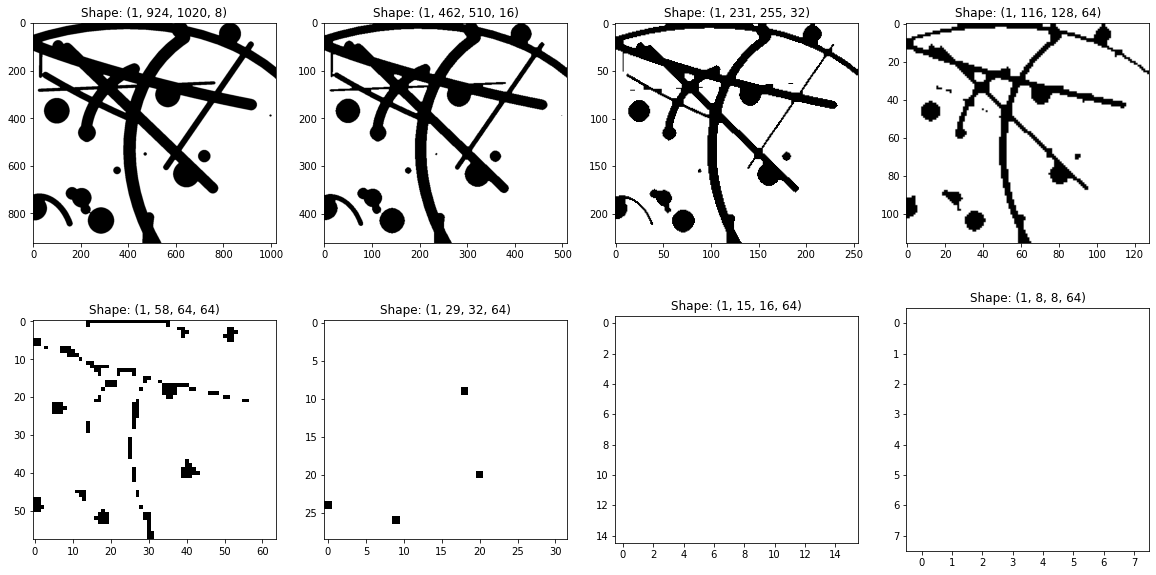

In [19]:
_, axes = plt.subplots(2, 4, figsize=(20, 10))
axes[0][0].imshow(o1[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][1].imshow(o2[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][2].imshow(o3[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][3].imshow(o4[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][0].imshow(o5[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][1].imshow(o6[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][2].imshow(o7[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[1][3].imshow(o8[0, :,:, 0], cmap = 'gray', vmin=0, vmax=1)
axes[0][0].set_title(f"Shape: {o1.shape}")
axes[0][1].set_title(f"Shape: {o2.shape}")
axes[0][2].set_title(f"Shape: {o3.shape}")
axes[0][3].set_title(f"Shape: {o4.shape}")
axes[1][0].set_title(f"Shape: {o5.shape}")
axes[1][1].set_title(f"Shape: {o6.shape}")
axes[1][2].set_title(f"Shape: {o7.shape}")
axes[1][3].set_title(f"Shape: {o8.shape}")
plt.show()

ARQUITECTURA UNET

In [20]:
import os
import sys
import numpy as np
from datetime import datetime

import tensorflow as tf
from keras.models import Model
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, UpSampling2D, Dropout, LeakyReLU, BatchNormalization, Activation, Lambda
from keras.layers.merge import Concatenate
from keras.applications import VGG16
from keras import backend as K
from keras.utils.multi_gpu_utils import multi_gpu_model



class PConvUnet(object):

    def __init__(self, img_rows=512, img_cols=512, vgg_weights="imagenet", inference_only=False, net_name='default', gpus=1, vgg_device=None):
        """Create the PConvUnet. If variable image size, set img_rows and img_cols to None
        
        Args:
            img_rows (int): image height.
            img_cols (int): image width.
            vgg_weights (str): which weights to pass to the vgg network.
            inference_only (bool): initialize BN layers for inference.
            net_name (str): Name of this network (used in logging).
            gpus (int): How many GPUs to use for training.
            vgg_device (str): In case of training with multiple GPUs, specify which device to run VGG inference on.
                e.g. if training on 8 GPUs, vgg inference could be off-loaded exclusively to one GPU, instead of
                running on one of the GPUs which is also training the UNet.
        """
        
        # Settings
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.img_overlap = 30
        self.inference_only = inference_only
        self.net_name = net_name
        self.gpus = gpus
        self.vgg_device = vgg_device

        # Scaling for VGG input
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]

        # Assertions
        assert self.img_rows >= 256, 'Height must be >256 pixels'
        assert self.img_cols >= 256, 'Width must be >256 pixels'

        # Set current epoch
        self.current_epoch = 0
        
        # VGG layers to extract features from (first maxpooling layers, see pp. 7 of paper)
        self.vgg_layers = [3, 6, 10]

        # Instantiate the vgg network
        if self.vgg_device:
            with tf.device(self.vgg_device):
                self.vgg = self.build_vgg(vgg_weights)
        else:
            self.vgg = self.build_vgg(vgg_weights)
        
        # Create UNet-like model
        if self.gpus <= 1:
            self.model, inputs_mask = self.build_pconv_unet()
            self.compile_pconv_unet(self.model, inputs_mask)            
        else:
            with tf.device("/cpu:0"):
                self.model, inputs_mask = self.build_pconv_unet()
            self.model = multi_gpu_model(self.model, gpus=self.gpus)
            self.compile_pconv_unet(self.model, inputs_mask)
        
    def build_vgg(self, weights="imagenet"):
        """
        Load pre-trained VGG16 from keras applications
        Extract features to be used in loss function from last conv layer, see architecture at:
        https://github.com/keras-team/keras/blob/master/keras/applications/vgg16.py
        """        
            
        # Input image to extract features from
        img = Input(shape=(self.img_rows, self.img_cols, 3))

        # Mean center and rescale by variance as in PyTorch
        processed = Lambda(lambda x: (x-self.mean) / self.std)(img)
        
        # If inference only, just return empty model        
        if self.inference_only:
            model = Model(inputs=img, outputs=[img for _ in range(len(self.vgg_layers))])
            model.trainable = False
            model.compile(loss='mse', optimizer='adam')
            return model
                
        # Get the vgg network from Keras applications
        if weights in ['imagenet', None]:
            vgg = VGG16(weights=weights, include_top=False)
        else:
            vgg = VGG16(weights=None, include_top=False)
            vgg.load_weights(weights, by_name=True)

        # Output the first three pooling layers
        vgg.outputs = [vgg.layers[i].output for i in self.vgg_layers]        
        
        # Create model and compile
        model = Model(inputs=img, outputs=vgg(processed))
        model.trainable = False
        model.compile(loss='mse', optimizer='adam')

        return model
        
    def build_pconv_unet(self, train_bn=True):      

        # INPUTS
        inputs_img = Input((self.img_rows, self.img_cols, 3), name='inputs_img')
        inputs_mask = Input((self.img_rows, self.img_cols, 3), name='inputs_mask')
        
        # ENCODER
        def encoder_layer(img_in, mask_in, filters, kernel_size, bn=True):
            conv, mask = PConv2D(filters, kernel_size, strides=2, padding='same')([img_in, mask_in])
            if bn:
                conv = BatchNormalization(name='EncBN'+str(encoder_layer.counter))(conv, training=train_bn)
            conv = Activation('relu')(conv)
            encoder_layer.counter += 1
            return conv, mask
        encoder_layer.counter = 0
        
        e_conv1, e_mask1 = encoder_layer(inputs_img, inputs_mask, 64, 7, bn=False)
        e_conv2, e_mask2 = encoder_layer(e_conv1, e_mask1, 128, 5)
        e_conv3, e_mask3 = encoder_layer(e_conv2, e_mask2, 256, 5)
        e_conv4, e_mask4 = encoder_layer(e_conv3, e_mask3, 512, 3)
        e_conv5, e_mask5 = encoder_layer(e_conv4, e_mask4, 512, 3)
        e_conv6, e_mask6 = encoder_layer(e_conv5, e_mask5, 512, 3)
        e_conv7, e_mask7 = encoder_layer(e_conv6, e_mask6, 512, 3)
        e_conv8, e_mask8 = encoder_layer(e_conv7, e_mask7, 512, 3)
        
        # DECODER
        def decoder_layer(img_in, mask_in, e_conv, e_mask, filters, kernel_size, bn=True):
            up_img = UpSampling2D(size=(2,2))(img_in)
            up_mask = UpSampling2D(size=(2,2))(mask_in)
            concat_img = Concatenate(axis=3)([e_conv,up_img])
            concat_mask = Concatenate(axis=3)([e_mask,up_mask])
            conv, mask = PConv2D(filters, kernel_size, padding='same')([concat_img, concat_mask])
            if bn:
                conv = BatchNormalization()(conv)
            conv = LeakyReLU(alpha=0.2)(conv)
            return conv, mask
            
        d_conv9, d_mask9 = decoder_layer(e_conv8, e_mask8, e_conv7, e_mask7, 512, 3)
        d_conv10, d_mask10 = decoder_layer(d_conv9, d_mask9, e_conv6, e_mask6, 512, 3)
        d_conv11, d_mask11 = decoder_layer(d_conv10, d_mask10, e_conv5, e_mask5, 512, 3)
        d_conv12, d_mask12 = decoder_layer(d_conv11, d_mask11, e_conv4, e_mask4, 512, 3)
        d_conv13, d_mask13 = decoder_layer(d_conv12, d_mask12, e_conv3, e_mask3, 256, 3)
        d_conv14, d_mask14 = decoder_layer(d_conv13, d_mask13, e_conv2, e_mask2, 128, 3)
        d_conv15, d_mask15 = decoder_layer(d_conv14, d_mask14, e_conv1, e_mask1, 64, 3)
        d_conv16, d_mask16 = decoder_layer(d_conv15, d_mask15, inputs_img, inputs_mask, 3, 3, bn=False)
        outputs = Conv2D(3, 1, activation = 'sigmoid', name='outputs_img')(d_conv16)
        
        # Setup the model inputs / outputs
        model = Model(inputs=[inputs_img, inputs_mask], outputs=outputs)

        return model, inputs_mask    

    def compile_pconv_unet(self, model, inputs_mask, lr=0.0002):
        model.compile(
            optimizer = Adam(lr=lr),
            loss=self.loss_total(inputs_mask),
            metrics=[self.PSNR]
        )

    def loss_total(self, mask):
        """
        Creates a loss function which sums all the loss components 
        and multiplies by their weights. See paper eq. 7.
        """
        def loss(y_true, y_pred):

            # Compute predicted image with non-hole pixels set to ground truth
            y_comp = mask * y_true + (1-mask) * y_pred

            # Compute the vgg features. 
            if self.vgg_device:
                with tf.device(self.vgg_device):
                    vgg_out = self.vgg(y_pred)
                    vgg_gt = self.vgg(y_true)
                    vgg_comp = self.vgg(y_comp)
            else:
                vgg_out = self.vgg(y_pred)
                vgg_gt = self.vgg(y_true)
                vgg_comp = self.vgg(y_comp)
            
            # Compute loss components
            l1 = self.loss_valid(mask, y_true, y_pred)
            l2 = self.loss_hole(mask, y_true, y_pred)
            l3 = self.loss_perceptual(vgg_out, vgg_gt, vgg_comp)
            l4 = self.loss_style(vgg_out, vgg_gt)
            l5 = self.loss_style(vgg_comp, vgg_gt)
            l6 = self.loss_tv(mask, y_comp)

            # Return loss function
            return l1 + 6*l2 + 0.05*l3 + 120*(l4+l5) + 0.1*l6

        return loss

    def loss_hole(self, mask, y_true, y_pred):
        """Pixel L1 loss within the hole / mask"""
        return self.l1((1-mask) * y_true, (1-mask) * y_pred)
    
    def loss_valid(self, mask, y_true, y_pred):
        """Pixel L1 loss outside the hole / mask"""
        return self.l1(mask * y_true, mask * y_pred)
    
    def loss_perceptual(self, vgg_out, vgg_gt, vgg_comp): 
        """Perceptual loss based on VGG16, see. eq. 3 in paper"""       
        loss = 0
        for o, c, g in zip(vgg_out, vgg_comp, vgg_gt):
            loss += self.l1(o, g) + self.l1(c, g)
        return loss
        
    def loss_style(self, output, vgg_gt):
        """Style loss based on output/computation, used for both eq. 4 & 5 in paper"""
        loss = 0
        for o, g in zip(output, vgg_gt):
            loss += self.l1(self.gram_matrix(o), self.gram_matrix(g))
        return loss
    
    def loss_tv(self, mask, y_comp):
        """Total variation loss, used for smoothing the hole region, see. eq. 6"""

        # Create dilated hole region using a 3x3 kernel of all 1s.
        kernel = K.ones(shape=(3, 3, mask.shape[3], mask.shape[3]))
        dilated_mask = K.conv2d(1-mask, kernel, data_format='channels_last', padding='same')

        # Cast values to be [0., 1.], and compute dilated hole region of y_comp
        dilated_mask = K.cast(K.greater(dilated_mask, 0), 'float32')
        P = dilated_mask * y_comp

        # Calculate total variation loss
        a = self.l1(P[:,1:,:,:], P[:,:-1,:,:])
        b = self.l1(P[:,:,1:,:], P[:,:,:-1,:])        
        return a+b

    def fit_generator(self, generator, *args, **kwargs):
        """Fit the U-Net to a (images, targets) generator
        Args:
            generator (generator): generator supplying input image & mask, as well as targets.
            *args: arguments to be passed to fit_generator
            **kwargs: keyword arguments to be passed to fit_generator
        """
        self.model.fit_generator(
            generator,
            *args, **kwargs
        )
        
    def summary(self):
        """Get summary of the UNet model"""
        print(self.model.summary())

    def load(self, filepath, train_bn=True, lr=0.0002):

        # Create UNet-like model
        self.model, inputs_mask = self.build_pconv_unet(train_bn)
        self.compile_pconv_unet(self.model, inputs_mask, lr) 

        # Load weights into model
        epoch = int(os.path.basename(filepath).split('.')[1].split('-')[0])
        assert epoch > 0, "Could not parse weight file. Should include the epoch"
        self.current_epoch = epoch
        self.model.load_weights(filepath)        

    @staticmethod
    def PSNR(y_true, y_pred):
        """
        PSNR is Peek Signal to Noise Ratio, see https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
        The equation is:
        PSNR = 20 * log10(MAX_I) - 10 * log10(MSE)
        
        Our input is scaled with be within the range -2.11 to 2.64 (imagenet value scaling). We use the difference between these
        two values (4.75) as MAX_I        
        """        
        #return 20 * K.log(4.75) / K.log(10.0) - 10.0 * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.0) 
        return - 10.0 * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.0) 

    @staticmethod
    def current_timestamp():
        return datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    @staticmethod
    def l1(y_true, y_pred):
        """Calculate the L1 loss used in all loss calculations"""
        if K.ndim(y_true) == 4:
            return K.mean(K.abs(y_pred - y_true), axis=[1,2,3])
        elif K.ndim(y_true) == 3:
            return K.mean(K.abs(y_pred - y_true), axis=[1,2])
        else:
            raise NotImplementedError("Calculating L1 loss on 1D tensors? should not occur for this network")
    
    @staticmethod
    def gram_matrix(x, norm_by_channels=False):
        """Calculate gram matrix used in style loss"""
        
        # Assertions on input
        assert K.ndim(x) == 4, 'Input tensor should be a 4d (B, H, W, C) tensor'
        assert K.image_data_format() == 'channels_last', "Please use channels-last format"        
        
        # Permute channels and get resulting shape
        x = K.permute_dimensions(x, (0, 3, 1, 2))
        shape = K.shape(x)
        B, C, H, W = shape[0], shape[1], shape[2], shape[3]
        
        # Reshape x and do batch dot product
        features = K.reshape(x, K.stack([B, C, H*W]))
        gram = K.batch_dot(features, features, axes=2)
        
        # Normalize with channels, height and width
        gram = gram /  K.cast(C * H * W, x.dtype)
        
        return gram
    
    # Prediction functions
    ######################
    def predict(self, sample, **kwargs):
        """Run prediction using this model"""
        return self.model.predict(sample, **kwargs)

In [21]:
import os
import gc
import copy

import numpy as np
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback

import matplotlib
import matplotlib.pyplot as plt

# Change to root path
if os.path.basename(os.getcwd()) != 'PConv-Keras':
    os.chdir('..')



# Settings
BATCH_SIZE = 4

# Imagenet Rescaling
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


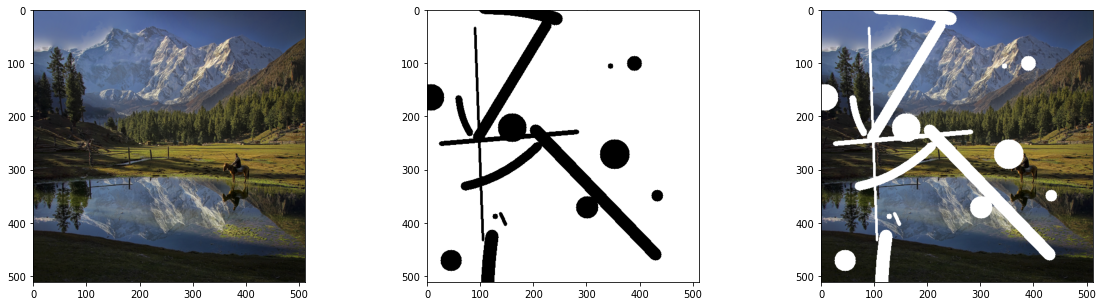

In [22]:
# Instantiate mask generator
mask_generator = MaskGenerator(512, 512, 3, rand_seed=42)
os.chdir("/content/drive/My Drive/UNSA/8 semestre/Proyecto fin de carrera/data/images")
# Load image
img = np.array(Image.open('0002.png').resize((512, 512))) / 255

# Load mask
mask = mask_generator.sample()

# Image + mask
masked_img = copy.deepcopy(img)
masked_img[mask==0] = 1

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(mask*255)
axes[2].imshow(masked_img)
plt.show()

Generador de datos

In [23]:
def plot_sample_data(masked, mask, ori, middle_title='Raw Mask'):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[:,:,:])
    axes[0].set_title('Masked Input')
    axes[1].imshow(mask[:,:,:])
    axes[1].set_title(middle_title)
    axes[2].imshow(ori[:,:,:])
    axes[2].set_title('Target Output')
    plt.show()

class DataGenerator(ImageDataGenerator):
    def flow(self, x, *args, **kwargs):
        while True:
            
            # Get augmentend image samples
            ori = next(super().flow(x, *args, **kwargs))

            # Get masks for each image sample
            mask = np.stack([mask_generator.sample() for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = copy.deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori        

# Create datagen
datagen = DataGenerator(  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Create generator from numpy array
batch = np.stack([img for _ in range(BATCH_SIZE)], axis=0)
generator = datagen.flow(x=batch, batch_size=BATCH_SIZE)

Mostrar resultados

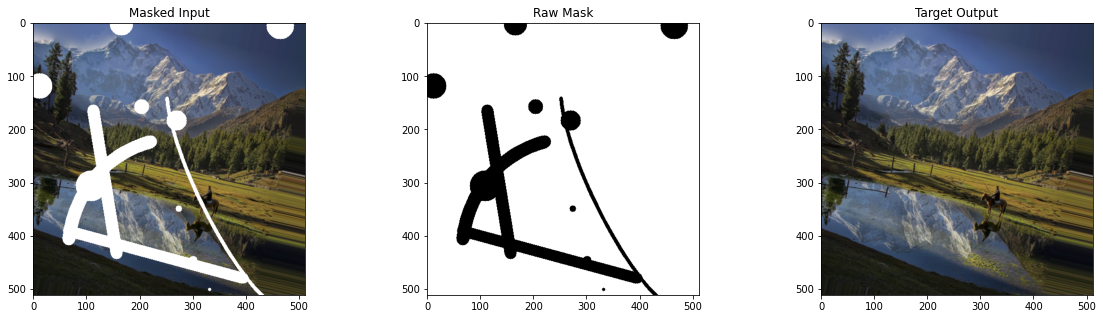

In [24]:
[m1, m2], o1 = next(generator)
plot_sample_data(m1[0], m2[0]*255, o1[0])

Entrenamiento con una sola imagen

In [25]:
os.chdir("/content/drive/My Drive/UNSA/8 semestre/Proyecto fin de carrera")
#!gdown --id 1HOzmKQFljTdKWftEP-kWD7p2paEaeHM0
#!unzip


In [26]:
!ls
model = PConvUnet(vgg_weights='pytorch_to_keras_vgg16.h5')

'Convoluciones parciales.ipynb'
 data
'Generative Image Inpainting.ipynb'
'Generative Image Inpainting with Contextual Attention.ipynb'
 pytorch_to_keras_vgg16.h5
 test
 train
 val

tracking <tf.Variable 'p_conv2d_9/Variable:0' shape=(7, 7, 3, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_10/Variable:0' shape=(5, 5, 64, 128) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_11/Variable:0' shape=(5, 5, 128, 256) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_12/Variable:0' shape=(3, 3, 256, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_13/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_14/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_15/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_16/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_17/Variable:0' 

Epoch 1/10
2000/2000 [==============================] - 1398s 699ms/step - loss: 3.2728 - PSNR: 17.4706



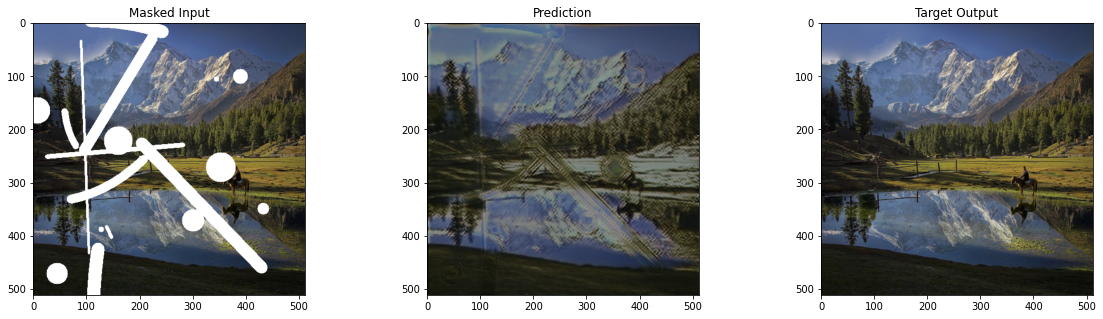

Epoch 2/10
 145/2000 [=>............................] - ETA: 21:34 - loss: 1.9003 - PSNR: 21.6791

KeyboardInterrupt: ignored

In [34]:
model.fit_generator(
    generator, 
    steps_per_epoch=2000,
    epochs=10,
    callbacks=[
        TensorBoard(
            log_dir='./data/logs/single_image_test',
            write_graph=False
        ),
        ModelCheckpoint(
            './data/logs/single_image_test/weights.{epoch:02d}-{loss:.2f}.h5',
            monitor='loss', 
            save_best_only=True, 
            save_weights_only=True
        ),
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_sample_data(
                masked_img, 
                model.predict(
                    [
                        np.expand_dims(masked_img,0), 
                        np.expand_dims(mask,0)
                    ]
                )[0]
                , 
                img,
                middle_title='Prediction'
            )
        )
    ],
)

Entrenamiento del modelo

In [28]:
import os
import gc
import datetime
import numpy as np
import pandas as pd
import cv2

from copy import deepcopy
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback
from keras import backend as K
from keras.utils import Sequence
from keras_tqdm import TQDMNotebookCallback

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

# Change to root path
if os.path.basename(os.getcwd()) != 'PConv-Keras':
    os.chdir('..')



%load_ext autoreload
%autoreload 2
plt.ioff()
os.chdir("/content/drive/My Drive/UNSA/8 semestre/Proyecto fin de carrera")
# SETTINGS
TRAIN_DIR = r"./train"
VAL_DIR = r"./val"
TEST_DIR = r"./test"

BATCH_SIZE = 4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
os.chdir("/content/drive/My Drive/UNSA/8 semestre/Proyecto fin de carrera")
class AugmentingDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, mask_generator, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)        
        seed = None if 'seed' not in kwargs else kwargs['seed']
        while True:
            
            # Get augmentend image samples
            ori = next(generator)
            print(ori)
            # Get masks for each image sample            
            mask = np.stack([
                mask_generator.sample(seed)
                for _ in range(ori.shape[0])], axis=0
            )

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori
            

# Create training generator
train_datagen = AugmentingDataGenerator(  
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, 
    MaskGenerator(512, 512, 3),
    target_size=(512, 512), 
    batch_size=BATCH_SIZE
)

# Create validation generator
val_datagen = AugmentingDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR, 
    MaskGenerator(512, 512, 3), 
    target_size=(512, 512), 
    batch_size=BATCH_SIZE, 
    classes=['val'], 
    seed=42
)

# Create testing generator
test_datagen = AugmentingDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, 
    MaskGenerator(512, 512, 3), 
    target_size=(512, 512), 
    batch_size=BATCH_SIZE, 
    seed=42
)

Ejemplo

In [30]:
test_data = next(test_generator)
(masked, mask), ori = test_data

for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

Found 0 images belonging to 0 classes.
[]


ValueError: ignored

DIV 2k

In [31]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
                
        plt.savefig(r'test_samples/img_{}_{}.png'.format(i, pred_time))
        plt.close()

In [32]:
os.chdir("/content/drive/My Drive/UNSA/8 semestre/Proyecto fin de carrera")
model = PConvUnet(vgg_weights='pytorch_to_keras_vgg16.h5')

tracking <tf.Variable 'p_conv2d_25/Variable:0' shape=(7, 7, 3, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_26/Variable:0' shape=(5, 5, 64, 128) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_27/Variable:0' shape=(5, 5, 128, 256) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_28/Variable:0' shape=(3, 3, 256, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_29/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_30/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_31/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_32/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_33/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_34/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_

In [33]:
FOLDER = './data/logs/imagenet_phase1_paperMasks'

# Run training for certain amount of epochs
model.fit_generator(
    train_generator, 
    steps_per_epoch=10000,
    validation_data=val_generator,
    validation_steps=1000,
    epochs=50,  
    verbose=0,
    callbacks=[
        TensorBoard(
            log_dir=FOLDER,
            write_graph=False
        ),
        ModelCheckpoint(
            FOLDER+'weights.{epoch:02d}-{loss:.2f}.h5',
            monitor='val_loss', 
            save_best_only=True, 
            save_weights_only=True
        ),
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_callback(model)
        ),
        TQDMNotebookCallback()
    ]
)

Found 0 images belonging to 1 classes.
[]


Se truncaron las últimas líneas 5000 del resultado de transmisión.

 [[[0.12941177 0.12917064 0.12084524]
   [0.12941177 0.12850757 0.11885601]
   [0.12941177 0.12784448 0.11686679]
   ...
   [0.17933808 0.17541651 0.16757338]
   [0.16283923 0.15891767 0.15107453]
   [0.16862746 0.16470589 0.15686275]]

  [[0.12216382 0.11853985 0.11069672]
   [0.12348998 0.12052908 0.11268594]
   [0.12481613 0.12251831 0.11467517]
   ...
   [0.17138118 0.1674596  0.15961647]
   [0.16482845 0.16090688 0.15306374]
   [0.16862746 0.16470589 0.15686275]]

  [[0.11800113 0.11764707 0.10980393]
   [0.1186642  0.11764707 0.10980393]
   [0.11932728 0.11764707 0.10980393]
   ...
   [0.16342427 0.1595027  0.15165956]
   [0.1668177  0.16289613 0.15505299]
   [0.16862746 0.16470589 0.15686275]]

  ...

  [[0.42278937 0.2627451  0.18538679]
   [0.38153332 0.19916677 0.10974957]
   [0.39384893 0.22343786 0.12281478]
   ...
   [0.12550093 0.08451423 0.04832452]
   [0.11425953 0.06691772 0.03450987]
   [0.12488473 0.

KeyboardInterrupt: ignored

[[[[0.73771834 0.7277187  0.7196451 ]
   [0.7845527  0.7779165  0.7447117 ]
   [0.8071919  0.7978909  0.7519336 ]
   ...
   [0.42598107 0.38284382 0.36715755]
   [0.42599076 0.3828535  0.36716723]
   [0.42600048 0.3828632  0.36717692]]

  [[0.8200047  0.80361    0.77662426]
   [0.86072123 0.84793127 0.799088  ]
   [0.89951223 0.8865304  0.83405334]
   ...
   [0.4029507  0.35981345 0.34412718]
   [0.40308645 0.3599492  0.34426293]
   [0.40322217 0.36008492 0.34439865]]

  [[0.7686108  0.74277604 0.72374344]
   [0.85604435 0.8421768  0.792735  ]
   [0.9141108  0.89380324 0.8454152 ]
   ...
   [0.38332644 0.3401892  0.32450292]
   [0.38322946 0.3400922  0.32440594]
   [0.38313255 0.3399953  0.324309  ]]

  ...

  [[0.05490196 0.05490196 0.0627451 ]
   [0.05624178 0.05490196 0.06676453]
   [0.05748373 0.05490196 0.0704904 ]
   ...
   [0.5254902  0.42352945 0.36078432]
   [0.5254902  0.42352945 0.36078432]
   [0.5254902  0.42352945 0.36078432]]

  [[0.05490196 0.05490196 0.0627451 ]
   [0.0

In [ ]:
# Load weights from previous run
model = PConvUnet()
model.load(
    r"C:\Users\Mathias Felix Gruber\Documents\GitHub\PConv-Keras\data\logs\imagenet_phase2\weights.26-1.07.h5",
    train_bn=False,
    lr=0.00005
)

In [ ]:
n = 0
for (masked, mask), ori in tqdm(test_generator):
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[0].xaxis.set_major_formatter(NullFormatter())
        axes[0].yaxis.set_major_formatter(NullFormatter())
        axes[1].xaxis.set_major_formatter(NullFormatter())
        axes[1].yaxis.set_major_formatter(NullFormatter())
                
        plt.savefig(r'data/test_samples/img_{}_{}.png'.format(i, pred_time))
        plt.close()
        n += 1
        
    # Only create predictions for about 100 images
    if n > 100:
        break

In [ ]:
# Store data
ratios = []
psnrs = []

# Loop through test masks released with paper
test_masks = os.listdir('./data/masks/test')
for filename in tqdm(test_masks):
    
    # Load mask from paper
    filepath = os.path.join('./data/masks/test', filename)
    mask = cv2.imread(filepath) / 255
    ratios.append(mask[:,:,0].sum() / (512 * 512))
    mask = np.array([1-mask for _ in range(BATCH_SIZE)])
    
    # Pick out image from test generator
    test_data = next(val_generator)
    (_, _), ori = test_data
    
    masked = deepcopy(ori)
    masked[mask==0] = 1
    
    # Run prediction on image & mask
    pred = model.predict([ori, mask])
    
    # Calculate PSNR
    psnrs.append(-10.0 * np.log10(np.mean(np.square(pred - ori))))

In [ ]:
df = pd.DataFrame({'ratios': ratios[:2408], 'psnrs': psnrs})

means, stds = [], []
idx1 = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
idx2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

for mi, ma in zip(idx1, idx2):
    means.append(df[(df.ratios >= mi) & (df.ratios <= ma)].mean())
    stds.append(df[(df.ratios >= mi) & (df.ratios <= ma)].std())
    
pd.DataFrame(means, index=['{}-{}'.format(a, b) for a, b in zip(idx1, idx2)])